In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "2"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [9]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results
Top performers were 125 words, followed by 60 and 250 for bestepoch and final models respectively.

""")


## Compare values for nwords

### Description
The number of words we extract from the labels and use to make the examples is a core component of the reference set. Essentially the thinking is the more words the better, however, that also exponentially increases the running time. In this experiment we adjust the number of words used in the example strings from 30 up to 250 (our maximum).

### Results
Top performers were 125 words, followed by 60 and 250 for bestepoch and final models respectively.



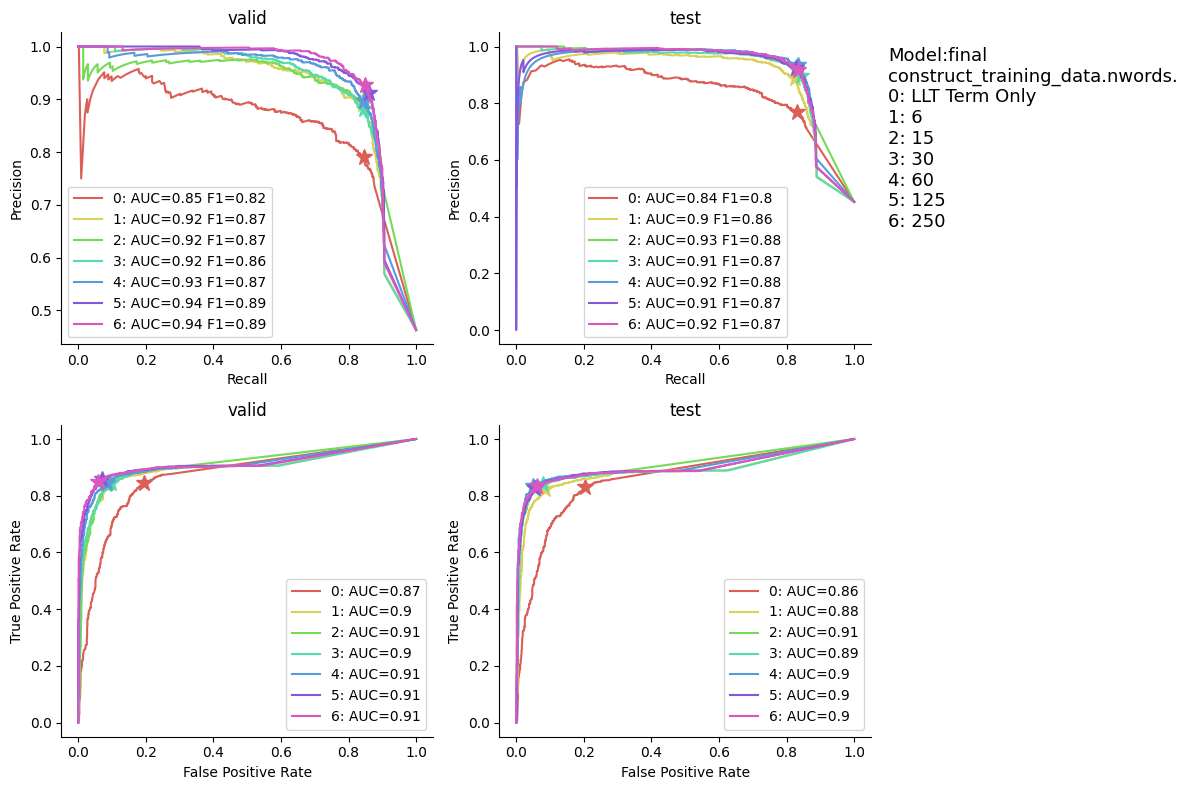

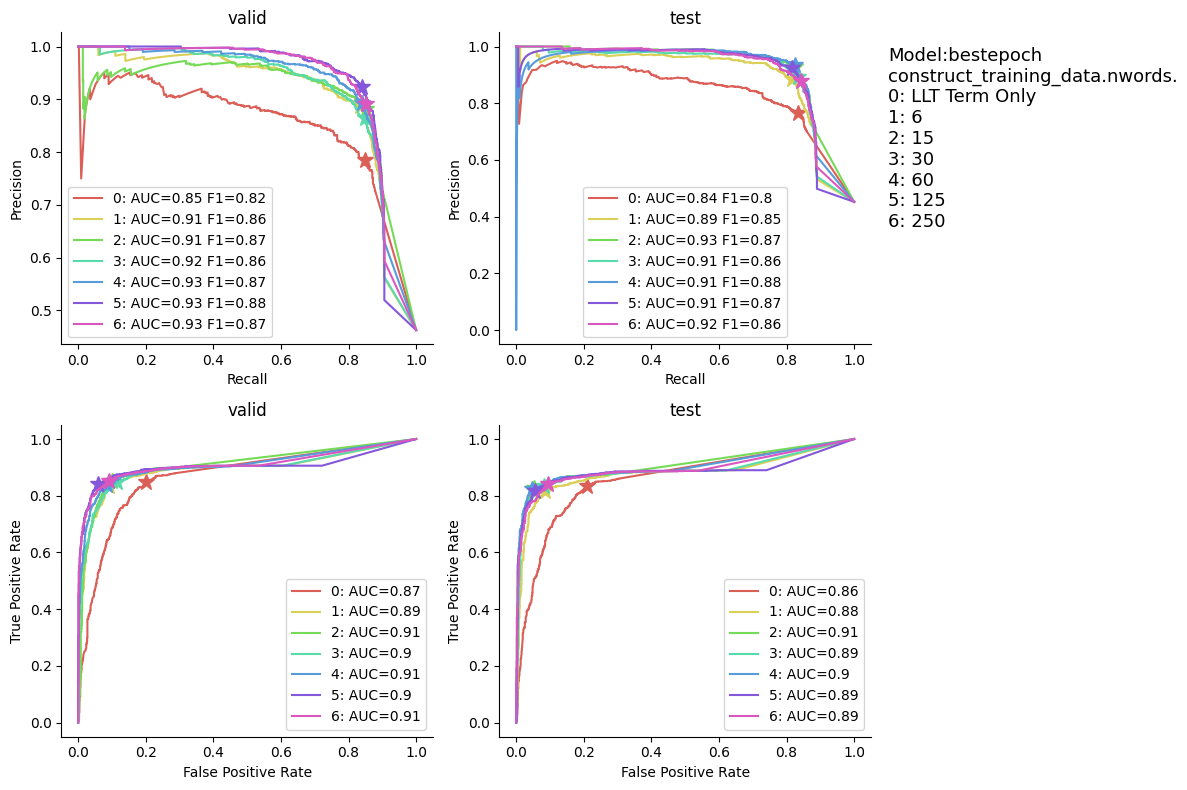

In [5]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,LLT Term Only,0.785,0.848,0.815,0.850,0.868,0.766,0.833,0.798,0.838,0.856
1,6,0.887,0.835,0.860,0.910,0.894,0.886,0.815,0.849,0.894,0.880
2,15,0.881,0.851,0.866,0.909,0.909,0.927,0.826,0.873,0.929,0.908
3,30,0.864,0.848,0.856,0.916,0.897,0.893,0.833,0.862,0.912,0.889
4,60,0.893,0.839,0.865,0.926,0.908,0.936,0.825,0.877,0.914,0.902
5,125,0.924,0.841,0.880,0.932,0.903,0.925,0.817,0.868,0.913,0.886
6,250,0.890,0.851,0.870,0.933,0.910,0.879,0.842,0.860,0.918,0.894


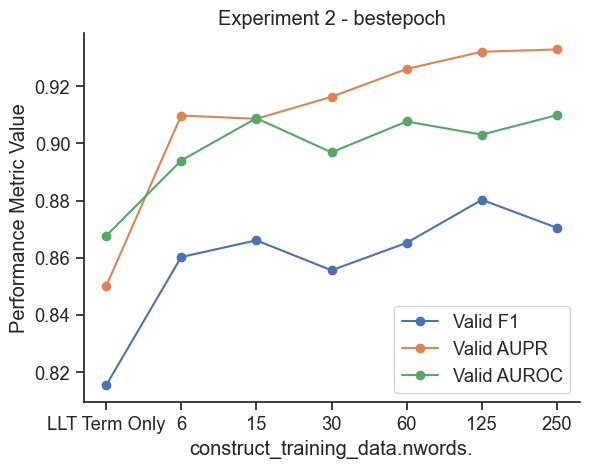

In [6]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'])
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,LLT Term Only,0.790,0.846,0.817,0.852,0.869,0.771,0.832,0.800,0.840,0.857
1,6,0.890,0.844,0.866,0.917,0.899,0.888,0.825,0.855,0.898,0.883
2,15,0.897,0.843,0.869,0.916,0.912,0.929,0.827,0.875,0.931,0.910
3,30,0.882,0.847,0.864,0.922,0.901,0.896,0.842,0.868,0.914,0.890
4,60,0.896,0.846,0.870,0.927,0.910,0.934,0.833,0.881,0.915,0.903
5,125,0.913,0.859,0.885,0.937,0.913,0.924,0.828,0.873,0.914,0.897
6,250,0.926,0.849,0.886,0.938,0.914,0.919,0.834,0.875,0.924,0.899


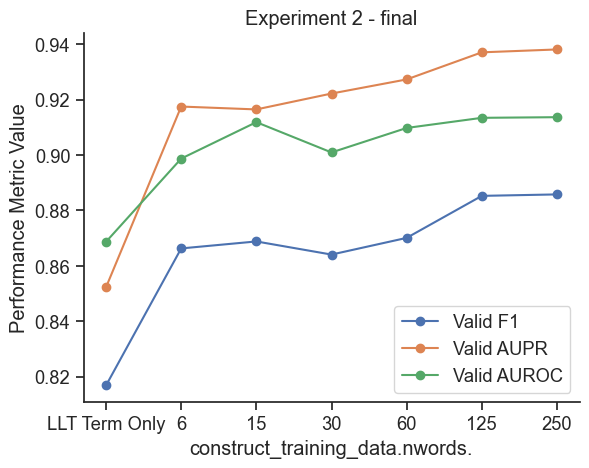

In [7]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'])
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

In [8]:
for fn in experiment['epochperf']:
    df = pd.read_csv(os.path.join('..', fn))
    print(fn, np.argmin(df['valid_loss']))

./results/epoch-results-CB_0-AR-3-all_222_24_25_1e-06_8_2048.csv 23
./results/epoch-results-CB_0-AR-6-all_222_24_25_1e-06_16_1024.csv 18
./results/epoch-results-CB_0-AR-15-all_222_24_25_1e-06_32_512.csv 20
./results/epoch-results-CB_0-AR-30-all_222_24_25_1e-06_64_256.csv 14
./results/epoch-results-CB_0-AR-60-all_222_24_25_1e-06_128_128.csv 10
./results/epoch-results-CB_0-AR-125-all_222_24_25_1e-06_256_32.csv 10
./results/epoch-results-CB_0-AR-250-all_222_24_25_1e-06_512_16.csv 5
